# Booking_Hotels_Ranking

# Tables des matières

* [Introduction](#Introduction)
* [Acquisition des données](#Acquisition-des-données)
* [Nettoyage des données et preprocessing](#)
* [Sélection et entrainement du modèle](#)
* [Exploitation du prédicteur](#)

# Introduction

Projet réalisé sur le site [Booking.com](https://www.booking.com/index.en-gb.html?label=gen173nr-1BCAEoggI46AdIM1gEaE2IAQGYAQm4ARfIAQzYAQHoAQGIAgGoAgO4AsiE4Z0GwAIB0gIkZTYzNDYwZjAtYzE5Yy00YWMzLWEzNWItZjkzNDlkNmU1ZDBl2AIF4AIB&sid=7ba9f340e388bcc1c3db52ff34b02dd7&keep_landing=1&sb_price_type=total).

**Problématique** : Trouver les variables qui influencent le prix d'une chambre d'hotel

# Acquisition des données

Récupération des données pour 2 villes : *Paris* et *Londres* avec comme caractéristiques imposées la réservation d'une nuit, du 15/01/2023 au 16/01/2023 pour 2 adultes.


Voir le scraping_final.py

Fonction *open_hotels* qui permet de récupérer différentes informations : 
- l'identifiant de l'hôtel
- le nom de l'hôtel
- l'adresse de l'hôtel
- la note de l'hôtel par les utilisateurs de *Booking*
- le nombre d'étoiles
- le type (si c'est un hôtel, appartement ...)
- le nombre de commentaires laissé sur cet hôtel par les utilisateurs de *Booking*
- les équipements de chaque chambre et de l'hôtel (salle de bain, chambre, ascenseur, parking, ...)
- les notes attribués aux différents services de l'hôtel (le personnel, le confort, le wifi, le rapport qualité-prix, ...)
- l'identifiant de la chambre
- le nom de la chambre
- la taille de la chambre
- **le prix de la chambre** (variable cible)
- le nombre de personnes puvant être accueillis dans la chambre
- la présence d'une promotion sur le prix récupéré
- information sur le petit déjeuner (inclu, prix, ...)
- les possibilités d'annulation (gratuite, possibilité de reprogrammer, ...)
- le moment de payer (à l'avance, sur place, ...)

Sortie json : Booking_Hotels_Paris.json (si la ville demandée est Paris)

![Rooms](Capture_Rooms.PNG)

# Nettoyage des données et preprocessing 

Voir le prepro_final.py

Nettoyage des données portant sur :
- le prix
- l'adresse
- le nombre de commentaires
- la note 
- l'annulation 
- le petit déjeuner
- la taille de la chambre 

Création de données : 
- les équipements des chambres et des hôtels
- les notes attribués aux services de l'hôtel
- une variable binaire qui informe sur la présence d'une promotion
- une variable binaire qui informe si l'annulation est gratuite
- une varaible binaire qui informe si un prépaiement est possible
- une variable binaire qui informe si le petit déjeuner et inclu
- le prix du petit déjeuner s'il n'est pas inclu

# Statistiques descriptives

#### Importations librairies et données

In [110]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import  DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.gaussian_process import GaussianProcessRegressor

import pandas as pd
import numpy as np
import json
import seaborn as sns

from rich import print
from rich.table import Table 
with open('Booking_Hotels_Paris_cleaned.json', 'r') as read_content:
    data = json.load(read_content)

Paris = pd.DataFrame(data)

In [101]:
summary = Table(
    "Variable",
    "Type",
    "NA"
)

In [102]:
for col in Paris.columns:
    NA = '/'
    if Paris[col].isnull().sum() != 0:
        NA = Paris[col].isnull().sum()
    summary.add_row(
        str(col),
        str(Paris[col].dtype),
        str(NA)
    )

In [99]:
list_facilities = []
for i in range(0, len(Paris)):
    for keys, values in Paris["Hotel_facilities"][i].items():
        if keys not in list_facilities:
            list_facilities.append(keys)
            
Paris = Paris.drop(['Room_id', 'Room_name', 'Room_promo', 'Room_breakfast','Room_cancellation', 'Room_prepayment', 'Hotel_id', 'Hotel_Name', 'Hotel_address', 'Hotel_type', 'Hotel_facilities', 'Hotel_categories', 'Hotel_Street', 'Hotel_City', 'Hotel_Country'], axis=1)
for facility in list_facilities:
    Paris = Paris.drop(columns=[f'{facility}'])

#### Présentation du dataset et de la variable cible :

In [103]:
summary

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━┓
┃ Variable                  ┃ Type    ┃ NA  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━┩
│ Room_price                │ int64   │ /   │
│ Room_sleeps               │ int64   │ /   │
│ Room_size                 │ float64 │ 323 │
│ Hotel_grade               │ float64 │ 7   │
│ Hotel_nb_reviews          │ int64   │ /   │
│ Hotel_stars               │ int64   │ /   │
│ Lift_bin                  │ int64   │ /   │
│ Luggage storage_bin       │ int64   │ /   │
│ No parking available._bin │ int64   │ /   │
│ Staff                     │ float64 │ 7   │
│ Facilities                │ float64 │ 7   │
│ Cleanliness               │ float64 │ 7   │
│ Comfort                   │ float64 │ 7   │
│ Value for money           │ float64 │ 7   │
│ Location                  │ float64 │ 7   │
│ Free WiFi                 │ float64 │ 145 │
│ Room_promo_bin            │ int64   │ /   │
│ Room_cancellation_bin     │ int64   │ /   │
│ Room_prepayment_bin       │ int64   │ /   │
│ Room_breakfast_bin        │ int64   │ /   │
│ Room_breakfast_price      │ float64 │ /   │
└───────────────────────────┴─────────┴─────┘

In [111]:
Paris_updated = Paris.dropna(axis=0)

In [112]:
Paris_updated.Hotel_type.value_counts()

Hotel                13924
Aparthotel             234
Hostel                  56
Apartments              46
Bed and breakfast       10
Name: Hotel_type, dtype: int64

In [113]:
i = Paris_updated[(Paris_updated.Hotel_type != 'Hotel')].index
Paris_updated = Paris_updated.drop(i)

<AxesSubplot:ylabel='Room_price'>

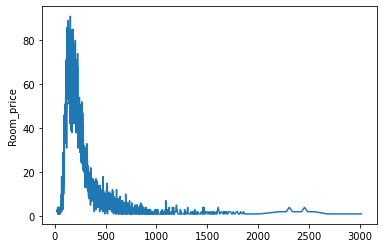

In [79]:
sns.lineplot(Paris.Room_price.value_counts())

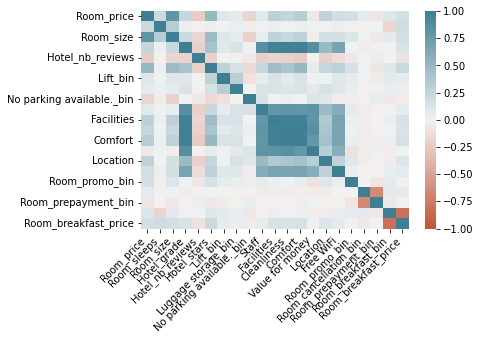

In [95]:
corr = Paris_updated.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=False
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Prix positivement corrélé avec :
 - Surface de la chambre
 - Nombre d'étoiles de l'hotel
 - Note globale de l'hotel
 - Notes de l'hotel par catégorie (aménagements, propreté, confort, localisation)
 - Nombre de couchages de la chambre
 
Prix négativement corrélé avec :
 - Nombre de reviews de l'hotel
 - Pas de parking

# Sélection et entrainement du modèle

### Settings

In [116]:
X = Paris_updated[
    [
    'Room_size', 
    'Room_promo_bin', 
    'Room_sleeps', 
    'Hotel_grade',
    'Staff', 
    'Facilities',
    'Cleanliness',
    'Comfort',
    'Value for money',
    'Location',
    'Free WiFi',
    'Hotel_nb_reviews',
    'Hotel_stars',
    'Room_cancellation_bin',
    'Room_prepayment_bin',
    'Room_breakfast_bin',
    'Room_breakfast_price'
    ]
]
y = Paris_updated['Room_price']

In [117]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y)

In [118]:
pl = Pipeline(
    [
        ("mise_echelle", MinMaxScaler()),
        ("support_vecteurs", SVR())
    ]
)

In [119]:
pl.get_params()

{'memory': None,
 'steps': [('mise_echelle', MinMaxScaler()), ('support_vecteurs', SVR())],
 'verbose': False,
 'mise_echelle': MinMaxScaler(),
 'support_vecteurs': SVR(),
 'mise_echelle__clip': False,
 'mise_echelle__copy': True,
 'mise_echelle__feature_range': (0, 1),
 'support_vecteurs__C': 1.0,
 'support_vecteurs__cache_size': 200,
 'support_vecteurs__coef0': 0.0,
 'support_vecteurs__degree': 3,
 'support_vecteurs__epsilon': 0.1,
 'support_vecteurs__gamma': 'scale',
 'support_vecteurs__kernel': 'rbf',
 'support_vecteurs__max_iter': -1,
 'support_vecteurs__shrinking': True,
 'support_vecteurs__tol': 0.001,
 'support_vecteurs__verbose': False}

In [120]:
pl_gs = GridSearchCV(
    pl,
    {
        'support_vecteurs__C': (0.1, 1.0, 10), #zone de sécurité, pénalisation(cb de membres de chaque famille il peut y avoir à l'extérieur de la bande)
        'support_vecteurs__epsilon': (0.1, 1.0, 10), #zone de confiance
    }
)
pl_gs_final = pl_gs.fit(X_tr, y_tr)

In [121]:
pl_gs_final.score(X_tr, y_tr)

0.6210317068991965

# Exploitation du prédicteur 